In [ ]:
"""
 - no merging APs - separate APs work better 
 - Average works best (99% 1 step + 2 steps, pixel) (98% 1 step + 2 steps, redmi)
 - weighting by power used / total power received doesn't work 
 - KS doesnt work 
 - Average > Median > Max 
 - random direction = disaster 
 - sometimes RSSI data from an AP is missing (not received) -> misclassification
"""

In [1]:
from utils import *
import sys, os, random
# from compare_locations import compare_locations

datadir = "../data.upb/precis/01-precis-redmi-pixel4a/nowl/"
#datadir = "../data.upb/precis/02-precis-redmi-pixel4a/"



In [4]:
# parter - face level 
#pix_etaje = ["0-pixel-04-06-2021_19-34-41.json"]
#red_etaje = ["0-redmi-04-06-2021_19-33-47.json"]

# whole building - hip level 
pix_etaje = [
"0-pixel-04-03-2021_15-32-38.json.gz",
 "1-pixel-25-02-2021_21-16-46.json.gz",
 "2-pixel-25-02-2021_16-27-45.json.gz",
 "3-pixel-04-03-2021_16-18-50.json.gz",
 "4-pixel-04-03-2021_16-43-50.json.gz",
 "5-pixel-04-03-2021_17-11-32.json.gz",
 "6-pixel-17-03-2021_12-52-29.json.gz",
 "7-pixel-17-03-2021_13-14-36.json.gz"
]

red_etaje = [
"0-redmi-04-03-2021_15-31-12.json.gz",
"1-redmi-25-02-2021_21-16-10.json.gz",
 "2-redmi-25-02-2021_16-27-08.json.gz",
 "3-redmi-04-03-2021_16-18-52.json.gz",
 "4-redmi-04-03-2021_16-43-45.json.gz",
 "5-redmi-04-03-2021_17-11-30.json.gz",
 "6-redmi-17-03-2021_12-52-29.json.gz",
 "7-redmi-17-03-2021_13-14-39.json.gz"
]


retaje = []
for e in red_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    for c in etaj:
        precalculate(c)
    retaje.append(etaj)

petaje = []
for e in pix_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    for c in etaj:
        precalculate(c)
    petaje.append(etaj)
    

In [9]:
import numpy as np
from scipy.spatial.distance import *
from scipy.stats import ks_2samp, chisquare
import copy 

def real_braycurtis(u, v, ex):
    """
    Compute the Bray-Curtis distance between two 1-D arrays.
    Bray-Curtis distance is defined as
    .. math::
       \\sum{|u_i-v_i|} / \\sum{|u_i+v_i|}
    The Bray-Curtis distance is in the range [0, 1] if all coordinates are
    positive, and is undefined if the inputs are of length zero.
    """
    l1_diff = abs(u - v)
    l1_sum = abs(u + v)
    
    return (abs(ex) + l1_diff.sum()) / (abs(ex) + l1_sum.sum())


def precalculate(c): # c is a collection
    """ creates new fields to speed up distance comparisons 
          c.ufingerprint['wifirssi'][mac] = average dBm 
    """
    ufingerprint = {}
    ufingerprint['wifirssi'] = {}
    for f in c['fingerprints']:
        if not "wifi" in f.keys():
            continue
        for mac in f["wifi"].keys():
            avg_pow = np.average(f["wifi"][mac]['rssi']) # each fingerprint (direction) counts the same
            if not mac in ufingerprint["wifirssi"].keys():
                ufingerprint["wifirssi"][mac] = [avg_pow] 
            else:
                ufingerprint["wifirssi"][mac].append(avg_pow)
    for mac in ufingerprint["wifirssi"].keys():
        ufingerprint["wifirssi"][mac] = \
            np.average(adjust_rssi(ufingerprint["wifirssi"][mac])) #each fingerprint (direction) counts the same
    c['ufingerprint'] = ufingerprint
                
def merge_wifi_fingerprints1(flist):
    if len(flist) == 1:
        return flist[0]
    fingerprint = copy.deepcopy(flist[0])
    for f2 in copy.deepcopy(flist[1:]):
        if not "wifi" in f2.keys():
            continue
        for mac in f2["wifi"].keys():
            if not mac in fingerprint["wifi"].keys():
                fingerprint["wifi"][mac] = f2["wifi"][mac]
            else:
                fingerprint["wifi"][mac]['rssi'].extend(f2["wifi"][mac]['rssi'])
            fingerprint["wifi"][mac]['rssi'].sort()    
    return fingerprint

def compare_locations(c1, c2, simil_method = braycurtis,  selection = 'Average', dif = True):
    # precalculated with average, adjust_rssi  
    wifi1 = c1['ufingerprint']['wifirssi']
    wifi2 = c2['ufingerprint']['wifirssi']      
    
    common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    # No APs in common -> similarity = 1
    if not common_aps:
        return 1.0

    if len(common_aps) * 5 <= len(wifi1.keys()) or len(common_aps) < 3:
        return 1.0

    aps1 = set(wifi1.keys()) - set(common_aps)
    aps2 = set(wifi2.keys()) - set(common_aps)
    rssi1 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    rssi2 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    nap = 0   #  
    
    if selection == 'First':
        for ap in common_aps:
            rssi1.append(wifi1[ap]['rssi'][0])
            rssi2.append(wifi2[ap]['rssi'][0])

        # Make an average of all RSSI values
    if selection == 'Average':
        for ap in common_aps:
            rssi1[nap] = wifi1[ap]
            rssi2[nap] = wifi2[ap]
            nap = nap + 1
            
    if selection == 'Median':
        for ap in common_aps:
            rssi1.append(np.median(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.median(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Mean':
        for ap in common_aps:
            rssi1.append(np.mean(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.mean(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Std':
        for ap in common_aps:
            rssi1.append(np.std(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.std(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Max':
        for ap in common_aps:
            rssi1.append(np.max(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.max(adjust_rssi(wifi2[ap]['rssi'])))
            
    if selection == 'KS':
        for ap in common_aps:
            _, p = ks_2samp(wifi1[ap]['rssi'], wifi2[ap]['rssi'])
            rssi1.append(p)
            rssi2.append(1.0)

    if (dif == True) and (selection != 'KS'):
        if len(rssi1) > nap:
            rssi1[nap] = rssi1[0]
            rssi2[nap] = rssi2[0]
        rssi1 = np.diff(rssi1, append=rssi1[0])
        rssi2 = np.diff(rssi2, append=rssi1[0])   

   
    """
    p1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), wifi1.keys())))
    p2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), wifi2.keys())))
    pc1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), common_aps)))
    pc2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), common_aps)))
    po1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), aps1)))
    po2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), aps2)))        
    iou = len(common_aps) / \
        (len(aps1) + len(aps2) + len(common_aps))
    """
        
    for ap in aps1:
        rssi1[nap] = 1.0*wifi1[ap]
        rssi2[nap] = adjust_rssi(-95.0)[0]
        nap = nap + 1
    for ap in aps2:
        rssi2[nap] = 1.0*wifi2[ap]
        rssi1[nap] = adjust_rssi(-95.0)[0]
        nap = nap + 1
        
    if simil_method == minkowski:    
        return minkowski(rssi1, rssi2, 2)/math.sqrt(len(rssi1))
    else:
        return simil_method(rssi1, rssi2)


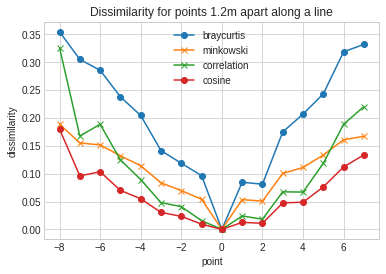

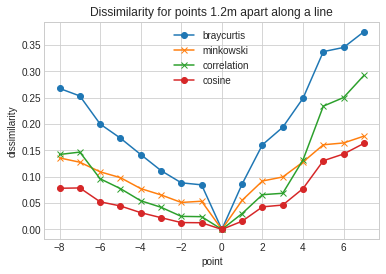

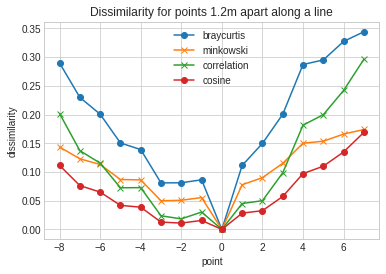

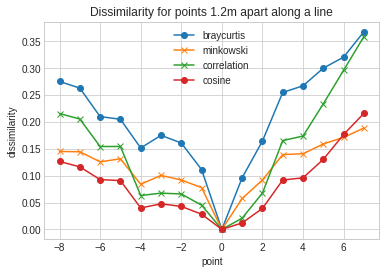

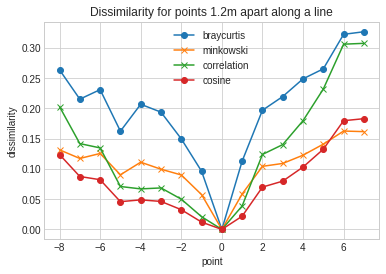

In [60]:
# visualize points on a floor in relation to their neighbors 
#
plt.style.use("seaborn-whitegrid")
fig =  plt.figure(figsize=(6, 4))  

etaje = retaje
etaj = 2
npct = len(etaje[etaj])
r = np.arange(0, npct)
for point in r[0:5]: 
    mx = np.array([])
    ks = np.array([])
    avg = np.array([])
    md = np.array([])
    ra = (np.arange(point-8, point+8) + npct)%npct
    for p in ra:
        mx = np.append(mx, compare_locations(etaje[etaj][point], etaje[etaj][p], 
                                             simil_method=braycurtis, dif=False))
        ks = np.append(ks, compare_locations(etaje[etaj][point], etaje[etaj][p], 
                                             simil_method=cosine, dif=False))
        avg = np.append(avg, compare_locations(etaje[etaj][point], etaje[etaj][p], 
                                               simil_method=minkowski, dif=False))
        md = np.append(md, compare_locations(etaje[etaj][point], etaje[etaj][p], 
                                             simil_method=correlation, dif=False))

    
    plt.plot(np.arange(0, len(ra))-8, mx, "o-", label='braycurtis')
    plt.plot(np.arange(0, len(ra))-8, avg, "x-", label='minkowski')   
    plt.plot(np.arange(0, len(ra))-8, md, "x-", label='correlation')    
    plt.plot(np.arange(0, len(ra))-8, ks, "o-", label='cosine')    
    plt.legend(loc="upper center", facecolor='red', framealpha=1, shadow=True, fancybox=True) 
    
    plt.xlabel('point')
    plt.ylabel('dissimilarity')
    plt.grid(True)
    plt.title(f"Dissimilarity for points 1.2m apart along a line")
    
    plt.show()
    fig.savefig(f"Monotonicity_{point}.pdf", bbox_inches='tight')
    


In [5]:
# Generate a matrix (list of lists) for a collection (etaj)
# [point_index, index_of_closest_pt, dist_to_closest_pt, index_diff, dist_2_best_neighbor]
def test_allvsall(collection, selection='Average'):
    lc = len(collection)
    #arr = [[0]*lc]*lc - nu merge!
    arr = [[0 for i in range(lc)] for j in range(lc)]
    for l in range(0, lc):
        for c in range(0, l):
            arr[l][c] = compare_locations(collection[l], collection[c], braycurtis, selection)
            arr[c][l] = arr[l][c]
        arr[l][l] = 1 # max 

   # print("#pt minpt mindist diff dist2nbr")
    listp = []
    for l in range(0, lc):
        mindist = min(arr[l])
        index_of_min = arr[l].index(mindist)
        diff = diff_modulo(l, arr[l].index(mindist), lc)
        distl=arr[l][(l-1+lc)%lc]
        distr=arr[l][(l+1)%lc]

        #print(l, index_of_min, mindist, diff, min(distl, distr))
        listp.append([l, index_of_min, mindist, diff, min(distl, distr)])
    return listp



def test_queryvsall(query, collections, selection='Average'):
    """
    query = collection, an array or fingerprints 
    collections = aray of collection, can be a floor  
    RETURNS (similarity, index, eu_distance)
    """
    min = 1.0 
    mini = -1; 
    for c in range(0, len(collections)):
        d = compare_locations(query, collections[c], braycurtis, selection)
        if d != 0 and d < min:
            min = d 
            mini = c
    return min,mini, \
            euclidean([query['x'], query['y'], query['z']],\
                       [collections[mini]['x'], collections[mini]['y'],collections[mini]['z']])

  
    

In [6]:
#  query = Pixel  
#  DB = redmi 
cl_sim = []
cl_steps = []
cl_dist = []

#for e in len(retaje):
for e in range(0, len(petaje)): 
    for p in range(0, len(petaje[e])):
        sim, index, d =  test_queryvsall(petaje[e][p], retaje[e], 'Average')
        # print(sim, diff_modulo(p, index, len(petaje[e])), d)
        cl_sim.append(sim)
        cl_steps.append(diff_modulo(p, index, len(petaje[e])))
        cl_dist.append(d)
   

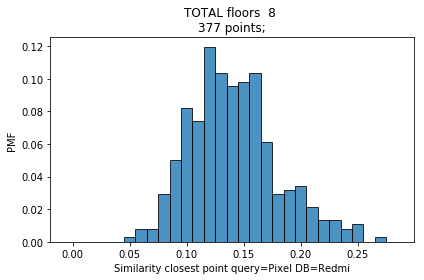

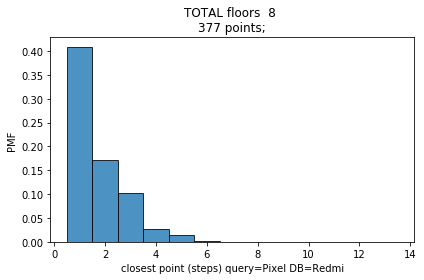

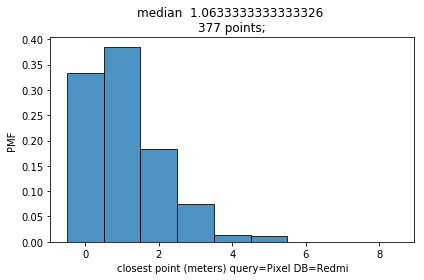

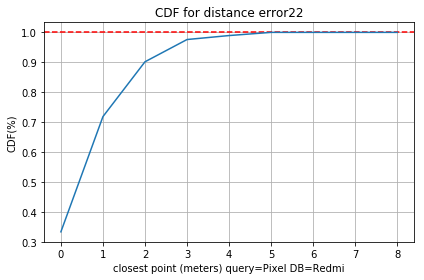

In [24]:

b = np.arange(0, 0.3, 0.01) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_sim), b, density=False)
hist_sim = hist_sim / len(cl_sim)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("Similarity closest point query=Pixel DB=Redmi")
plt.ylabel("PMF")
plt.title("{} {} \n{}{}".format("TOTAL floors ", len(retaje), len(cl_sim), " points;"))
plt.tight_layout()
plt.show()
#    fig.savefig(f"{method}-{len(etaje)}.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)

b = np.arange(1, 15, 1) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_steps), b, density=False)
hist_sim = hist_sim / len(cl_sim)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("closest point (steps) query=Pixel DB=Redmi")
plt.ylabel("PMF")
plt.title("{} {} \n{}{}".format("TOTAL floors ", len(retaje), len(cl_sim), " points;"))
plt.tight_layout()
plt.show()
#    fig.savefig(f"{method}-{len(etaje)}.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)



b = np.arange(0, 10, 1) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_dist), b, density=False)
hist_sim = hist_sim / len(cl_sim)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("closest point (meters) query=Pixel DB=Redmi")
plt.ylabel("PMF")
plt.title("{} {} \n{}{}".format("median ", np.median(cl_dist), len(cl_sim), " points;"))
plt.tight_layout()
plt.show()
#    fig.savefig(f"{method}-{len(etaje)}.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)

cdf=np.cumsum(hist_sim)
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel("closest point (meters) query=Pixel DB=Redmi")
plt.ylabel("CDF(%)")
plt.title("{}{}".format("CDF for distance error", 22))
plt.plot(b[:-1], cdf)
plt.grid(True)
plt.tight_layout()
plt.show()



In [254]:
#  query = Redmi  
#  DB = Pixel
cl_sim = []
cl_steps = []
cl_dist = []

#for e in len(retaje):
for e in range(0, len(retaje)): 
    for p in range(0, len(retaje[e])):
        sim, index, d =  test_queryvsall(retaje[e][p], petaje[e], 'Average')
        # print(sim, diff_modulo(p, index, len(petaje[e])), d)
        cl_sim.append(sim)
        cl_steps.append(diff_modulo(p, index, len(petaje[e])))
        cl_dist.append(d)


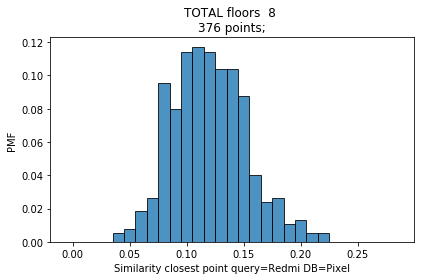

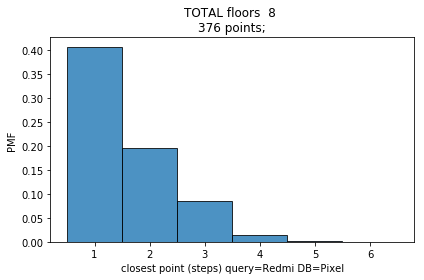

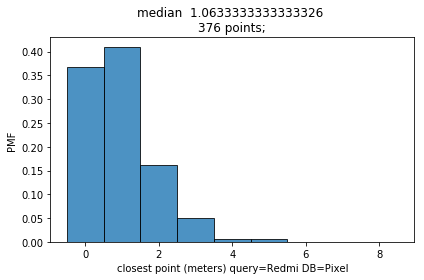

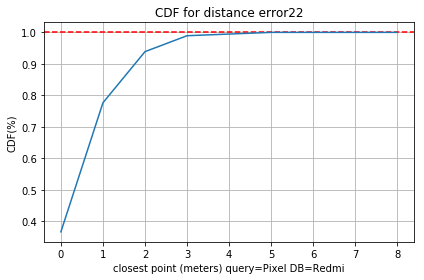

In [9]:

b = np.arange(0, 0.3, 0.01) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_sim), b, density=False)
hist_sim = hist_sim / len(cl_sim)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("Similarity closest point query=Redmi DB=Pixel")
plt.ylabel("PMF")
plt.title("{} {} \n{}{}".format("TOTAL floors ", len(petaje), len(cl_sim), " points;"))
plt.tight_layout()
plt.show()
#    fig.savefig(f"{method}-{len(etaje)}.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)

b = np.arange(1, 8, 1) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_steps), b, density=False)
hist_sim = hist_sim / len(cl_sim)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("closest point (steps) query=Redmi DB=Pixel")
plt.ylabel("PMF")
plt.title("{} {} \n{}{}".format("TOTAL floors ", len(petaje), len(cl_sim), " points;"))
plt.tight_layout()
plt.show()
#    fig.savefig(f"{method}-{len(etaje)}.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)



b = np.arange(0, 10, 1) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_dist), b, density=False)
hist_sim = hist_sim / len(cl_sim)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("closest point (meters) query=Redmi DB=Pixel")
plt.ylabel("PMF")
plt.title("{} {} \n{}{}".format("median ", np.median(cl_dist), len(cl_sim), " points;"))
plt.tight_layout()
plt.show()
#    fig.savefig(f"{method}-{len(etaje)}.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)

cdf=np.cumsum(hist_sim)
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel("closest point (meters) query=Pixel DB=Redmi")
plt.ylabel("CDF(%)")
plt.title("{}{}".format("CDF for distance error", 22))
plt.plot(b[:-1], cdf)
plt.grid(True)
plt.tight_layout()
plt.show()



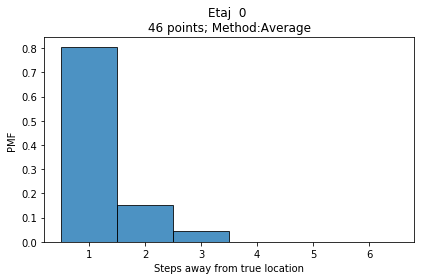

Percentages:  [0.80434783 0.15217391 0.04347826 0.         0.         0.        ]


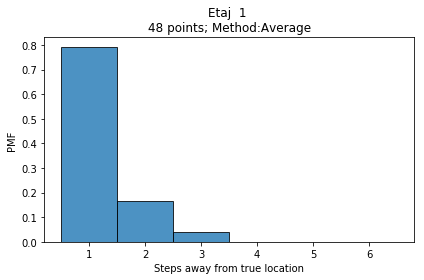

Percentages:  [0.79166667 0.16666667 0.04166667 0.         0.         0.        ]


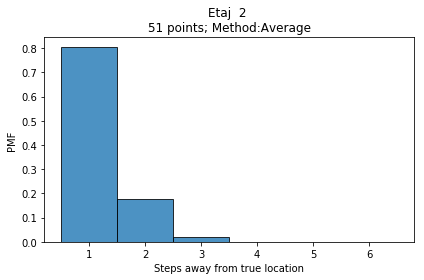

Percentages:  [0.80392157 0.17647059 0.01960784 0.         0.         0.        ]


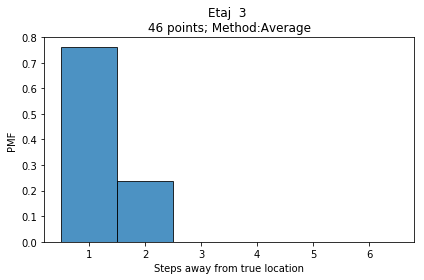

Percentages:  [0.76086957 0.23913043 0.         0.         0.         0.        ]


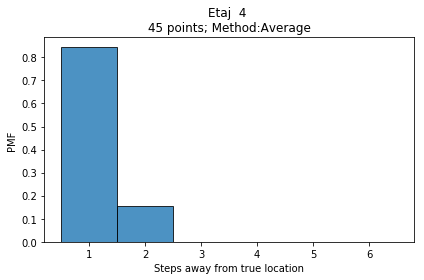

Percentages:  [0.84444444 0.15555556 0.         0.         0.         0.        ]


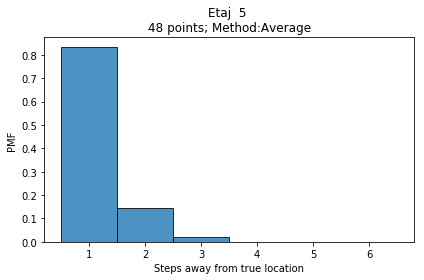

Percentages:  [0.83333333 0.14583333 0.02083333 0.         0.         0.        ]


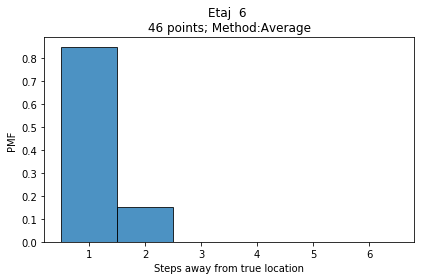

Percentages:  [0.84782609 0.15217391 0.         0.         0.         0.        ]


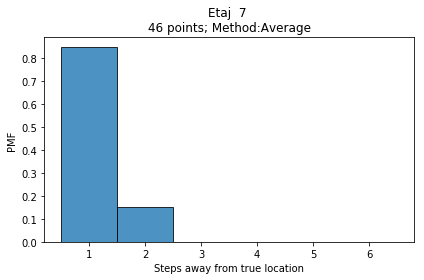

Percentages:  [0.84782609 0.15217391 0.         0.         0.         0.        ]


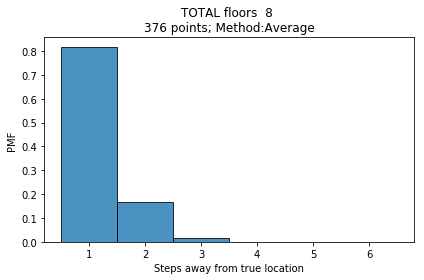

Percentages:  [0.81648936 0.16755319 0.01595745 0.         0.         0.        ]


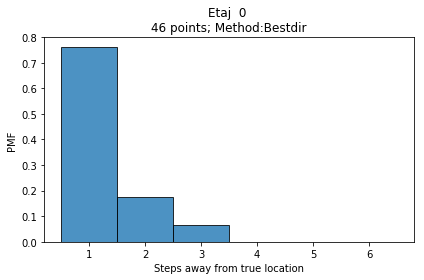

Percentages:  [0.76086957 0.17391304 0.06521739 0.         0.         0.        ]


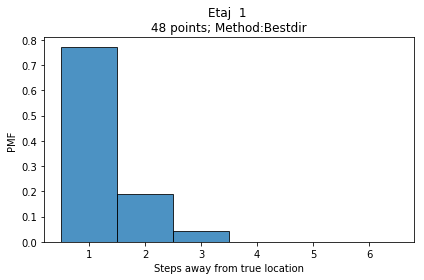

Percentages:  [0.77083333 0.1875     0.04166667 0.         0.         0.        ]


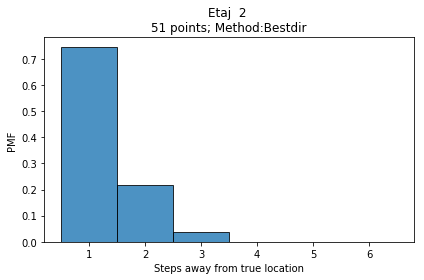

Percentages:  [0.74509804 0.21568627 0.03921569 0.         0.         0.        ]


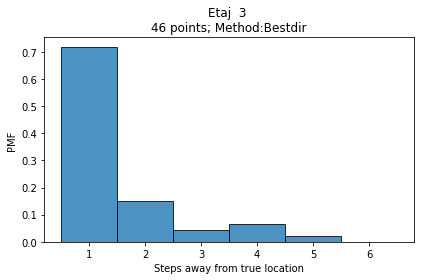

Percentages:  [0.7173913  0.15217391 0.04347826 0.06521739 0.02173913 0.        ]


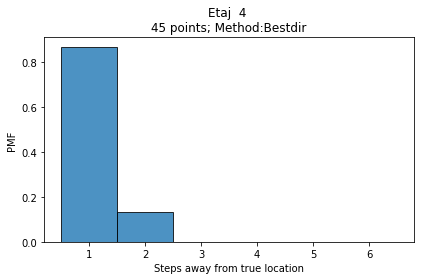

Percentages:  [0.86666667 0.13333333 0.         0.         0.         0.        ]


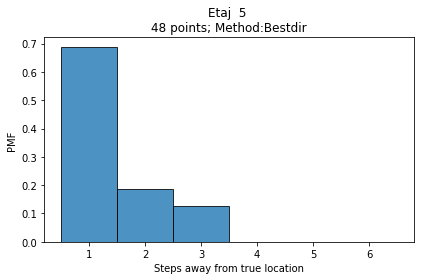

Percentages:  [0.6875 0.1875 0.125  0.     0.     0.    ]


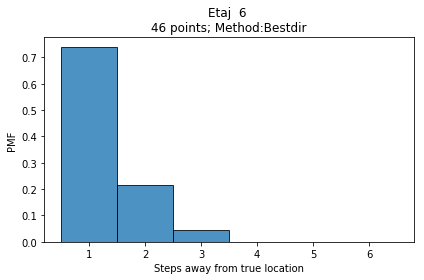

Percentages:  [0.73913043 0.2173913  0.04347826 0.         0.         0.        ]


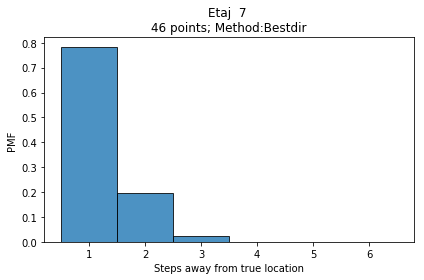

Percentages:  [0.7826087  0.19565217 0.02173913 0.         0.         0.        ]


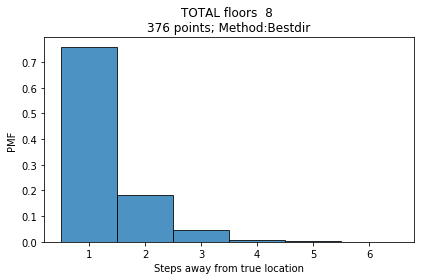

Percentages:  [0.75797872 0.18351064 0.04787234 0.00797872 0.00265957 0.        ]


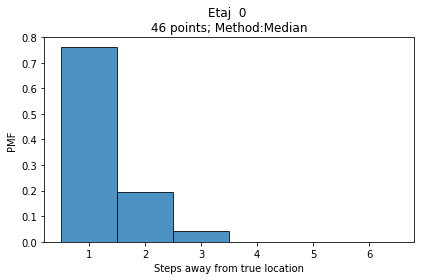

Percentages:  [0.76086957 0.19565217 0.04347826 0.         0.         0.        ]


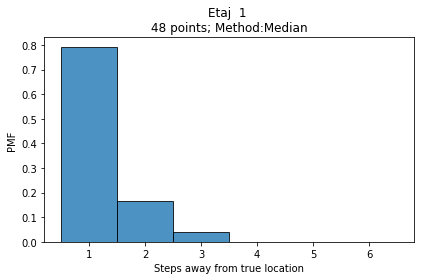

Percentages:  [0.79166667 0.16666667 0.04166667 0.         0.         0.        ]


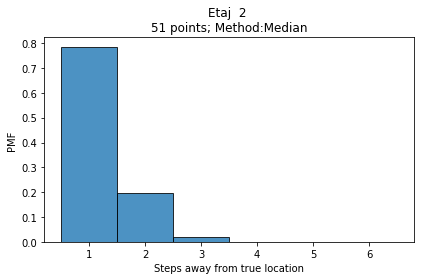

Percentages:  [0.78431373 0.19607843 0.01960784 0.         0.         0.        ]


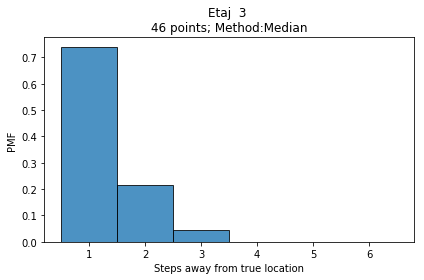

Percentages:  [0.73913043 0.2173913  0.04347826 0.         0.         0.        ]


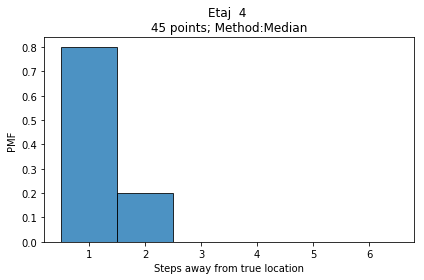

Percentages:  [0.8 0.2 0.  0.  0.  0. ]


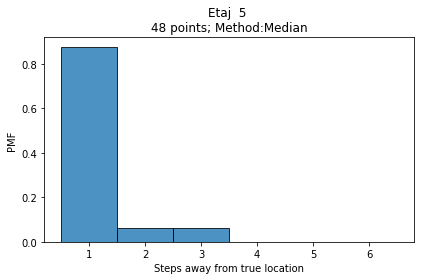

Percentages:  [0.875  0.0625 0.0625 0.     0.     0.    ]


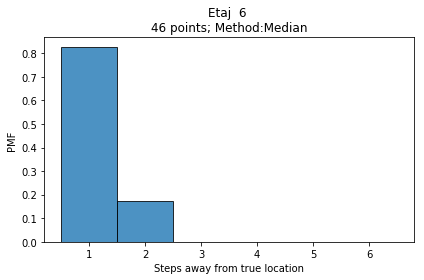

Percentages:  [0.82608696 0.17391304 0.         0.         0.         0.        ]


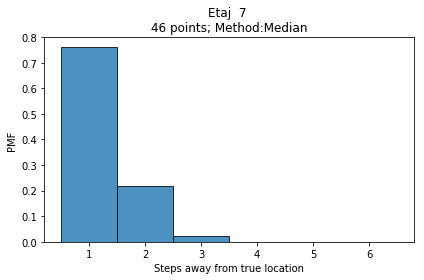

Percentages:  [0.76086957 0.2173913  0.02173913 0.         0.         0.        ]


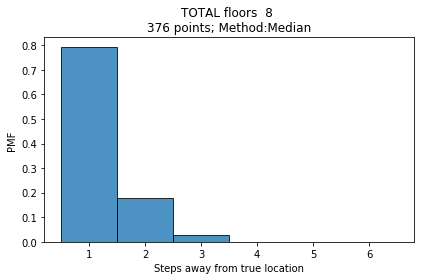

Percentages:  [0.79255319 0.17819149 0.02925532 0.         0.         0.        ]


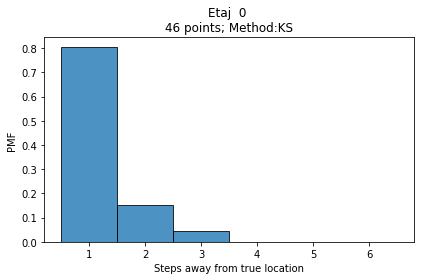

Percentages:  [0.80434783 0.15217391 0.04347826 0.         0.         0.        ]


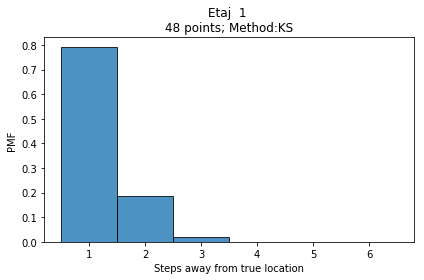

Percentages:  [0.79166667 0.1875     0.02083333 0.         0.         0.        ]


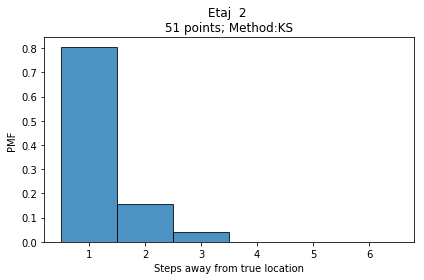

Percentages:  [0.80392157 0.15686275 0.03921569 0.         0.         0.        ]


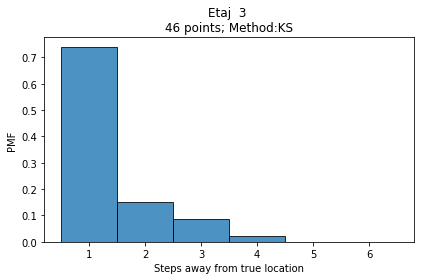

Percentages:  [0.73913043 0.15217391 0.08695652 0.02173913 0.         0.        ]


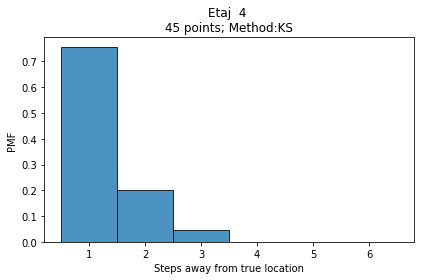

Percentages:  [0.75555556 0.2        0.04444444 0.         0.         0.        ]


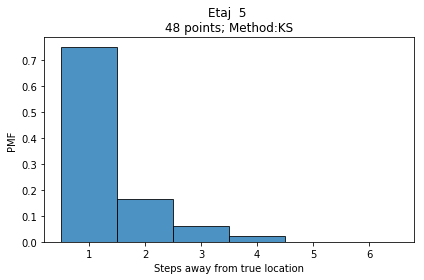

Percentages:  [0.75       0.16666667 0.0625     0.02083333 0.         0.        ]


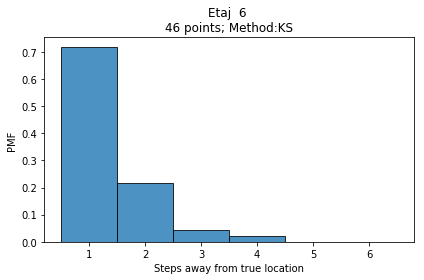

Percentages:  [0.7173913  0.2173913  0.04347826 0.02173913 0.         0.        ]


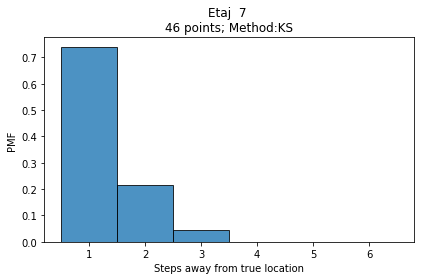

Percentages:  [0.73913043 0.2173913  0.04347826 0.         0.         0.        ]


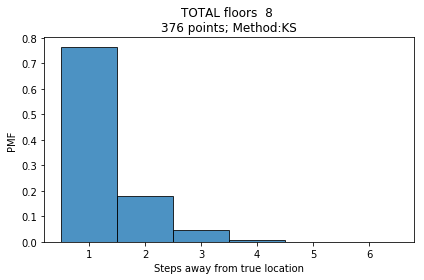

Percentages:  [0.76329787 0.18085106 0.04787234 0.00797872 0.         0.        ]


In [12]:
etaje = retaje
for method in ['Average', 'Bestdir', 'Median', 'KS']:
#for method in ['Max', 'Median', 'KS']:
    e = 0 
    total_nearest = []
    for etaj in etaje: 
        max_nearest = test_allvsall(etaj, method)
        total_nearest = total_nearest +  max_nearest
        
        nearest = np.array(max_nearest)
               
        away = nearest[:, 3] # steps away from true 
        b = np.arange(1, 8, 1) # Bins of histogram - from 1 to 5 
        bin_width = b[1] - b[0]

        hist_away, bins_out = np.histogram(away, b, density=False)

        hist_away = hist_away / away.size

        fig = plt.figure()
        plt.bar(b[:-1], hist_away, width=bin_width, ec='k', alpha=0.8)
        plt.xlabel("Steps away from true location")
        plt.ylabel("PMF")
        plt.title("{} {} \n{}{} Method:{}".format("Etaj ", e, len(nearest), " points;", method))
        e = e + 1
        plt.tight_layout()
        
        plt.show()
        print("Percentages: ", hist_away)
        
                
    away = np.array(total_nearest)[:, 3] # steps away from true 
    b = np.arange(1, 8, 1) # Bins of histogram - from 1 to 5 
    bin_width = b[1] - b[0]

    hist_away, bins_out = np.histogram(away, b, density=False)

    hist_away = hist_away / away.size

    fig = plt.figure()
    plt.bar(b[:-1], hist_away, width=bin_width, ec='k', alpha=0.8)
    plt.xlabel("Steps away from true location")
    plt.ylabel("PMF")
    plt.title("{} {} \n{}{} Method:{}".format("TOTAL floors ", len(etaje), len(total_nearest), " points;", method))
    e = e + 1
    plt.tight_layout()

    plt.show()
    fig.savefig(f"{method}-{len(etaje)}.pdf", bbox_inches='tight')
    print("Percentages: ", hist_away)
        

In [ ]:
good_pts = nearest[away == 1]
dists = good_pts[:, 2] # steps away from true 
b = np.arange(0, 0.3, 0.01) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]

hist_away, bins_out = np.histogram(dists, b, density=False)

hist_away = hist_away / away.size

fig = plt.figure()
plt.bar(b[:-1], hist_away, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("Steps away from true location")
plt.ylabel("PMF")
plt.title("{}\n{}{}".format("Distribution of distances across ", len(dists), " good points (closest is 1 step away)"))

plt.tight_layout()
#fig.savefig(os.path.join(save_img_dir, fn))
plt.show()
print("Mean Std =", np.mean(dists), np.std(dists))

In [15]:
"""
Statistics about measuement in 4 cardinal directions:

- we need to measure in several directions 
- at a location, only 60% of APs appear in all 4 directions 
- when turing 90deg, 87% of APs remain common, 13% are lost, 13% are gained 
- when reading in three directions, 50% of RSSI changes more than 6dBm, and 10% changes more than ~10dBm
- when reading in three directions, 50% of RSSI changes more than 9dBm, and 10% changes more than ~15dBm
"""

etaje = petaje# + retaje 
#f = merge_wifi_fingerprints(etaje[0][2]['fingerprints'])
#print(f)
APstats = {'total0':[], 'total2':[], 'total3':[], 'total4':[], \
           'common':[], 'lost':[], 'gained':[], \
           'ndirs':[], 'dbmdiff2':[], 'dbmdiff3':[], 'dbmdiff4':[]\
          }
for e in etaje: 
    for c in e:
        f = c['fingerprints']
        allf = merge_wifi_fingerprints1(f)['wifi']
        for mac in allf:
            APstats['ndirs'].append(len(allf[mac]['rssi'])) # number of directions an AP is visible
            if len(allf[mac]['rssi'])==2:
                APstats['dbmdiff2'].append(max(allf[mac]['rssi']) - min(allf[mac]['rssi'])) # max dBm difference 
            if len(allf[mac]['rssi'])==3:
                APstats['dbmdiff3'].append(max(allf[mac]['rssi']) - min(allf[mac]['rssi'])) # max dBm difference 
            if len(allf[mac]['rssi'])==4:    
                APstats['dbmdiff4'].append(max(allf[mac]['rssi']) - min(allf[mac]['rssi'])) # max dBm difference 

        for d in range(0,4): # for harvesting N/E/S/W directions without preproc
            m0 = set(f[d]['wifi'].keys())
            m1 = set(f[(d+1) % 4]['wifi'].keys())
            m2 = set(f[(d+1) % 4]['wifi'].keys())
            m3 = set(f[(d+1) % 4]['wifi'].keys())
            m4 = set(f[(d+1) % 4]['wifi'].keys())
            #print(len(m0), len(m0 & m1)/len(m0), len(m0 - m1)/len(m0), len(m1 - m0)/len(m0))  
            APstats['total0'].append(len(m0))              # totalAPs
            APstats['total2'].append(len(m0 | m1))              # totalAPs
            APstats['total3'].append(len(m0 | m1 | m2))              # totalAPs
            APstats['total4'].append(len(allf))              # totalAPs
            
            APstats['common'].append(len(m0 & m1)/len(m0)) # fraction of APs common  
            APstats['lost'].append(len(m0 - m1)/len(m0))   # lost APs
            APstats['gained'].append(len(m1 - m0)/len(m0)) # gained APs


In [16]:
# save in previous cell, the uncomment one below to save dataset for phone p, or r
#rAPstats=APstats
pAPstats=APstats


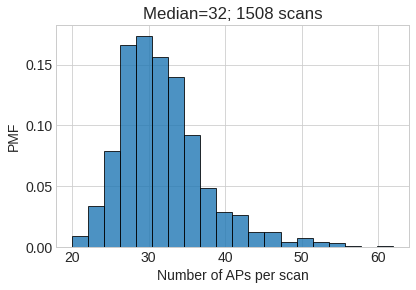

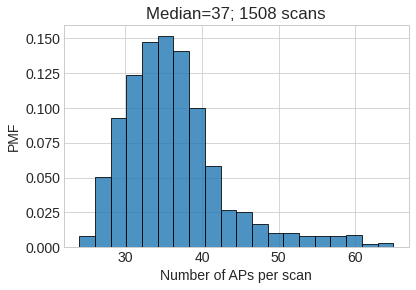

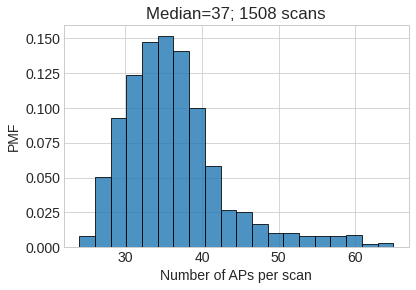

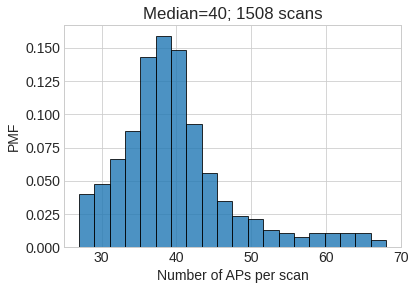

AttributeError: 'AxesSubplot' object has no attribute 'rc'

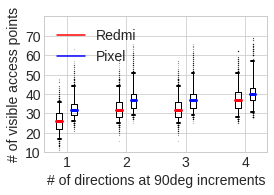

In [22]:

for stat in ['total0', 'total2', 'total3', 'total4']: 
    a = np.array(APstats[stat])
    hist_bars, bins_out = np.histogram(APstats[stat], bins=20, density=False)
    bin_width = bins_out[1] - bins_out[0]
    hist_bars = hist_bars / len(APstats[stat])
    fig = plt.figure()
    plt.style.use("seaborn-whitegrid")
    plt.bar(bins_out[:-1], hist_bars, width=bin_width, ec='k', alpha=0.8)
    plt.xlabel('Number of APs per scan')
    plt.ylabel("PMF")
    plt.tight_layout()
    plt.title(f"Median={np.median(APstats[stat]):.0f}; {len(APstats[stat])} scans")
    plt.show()
    fig.savefig(f"{stat}.pdf", bbox_inches='tight')



plt.style.use("seaborn-whitegrid")        
fig1, ax1 = plt.subplots(figsize=(4, 2.5))
ticks=['1', '2', '3', '4']

rbp = ax1.boxplot([rAPstats['total0'], rAPstats['total2'], 
            rAPstats['total3'], rAPstats['total4']],
            positions=np.array(range(len(ticks)))*2 - .25, 
            whis=(5,95),widths=0.2, 
            flierprops=dict(marker='o', markersize=.10, alpha=0.9), 
            whiskerprops=dict(color='k', linestyle='-'), 
            capprops = dict(color='k', linewidth=2),
            medianprops = dict(color='#ff0011', linewidth=3)
    )
#plt.setp(rbp['whiskers'], color='b', linestyle='-')
#plt.setp(rbp['caps'], color='b', linewidth=3)

pbp = ax1.boxplot([pAPstats['total0'], pAPstats['total2'], 
            pAPstats['total3'], pAPstats['total4']],
            positions=np.array(range(len(ticks)))*2 + .25, 
            whis=(5,95),widths=0.2,
            flierprops=dict(marker='o', markersize=.10, alpha=0.9), 
            whiskerprops=dict(color='k', linestyle='-'), 
            capprops = dict(color='k', linewidth=2),
            medianprops = dict(color='#0011ff', linewidth=3)
    )
ax1.plot([], c='r', label='Redmi')
ax1.plot([], c='b', label='Pixel')
ax1.legend()

ax1.set_xticks(range(0, len(ticks) * 2, 2))
ax1.set_yticks(np.arange(0, 80, 10))
ax1.set_xticklabels(ticks)
#ax1.set_xlim(-2, len(ticks)*2)
ax1.set_ylim(10, 80)
ax1.set_xlabel("# of directions at 90deg increments")
ax1.set_ylabel("# of visible access points")
plt.rc('font', size=14) 
fig1.tight_layout()
plt.show()
fig1.savefig("APs_gained_when_rotating.pdf", bbox_inches='tight')    
    



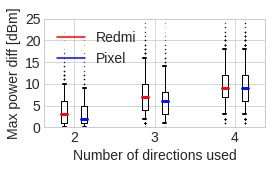

In [26]:
plt.style.use("seaborn-whitegrid")        
fig1, ax1 = plt.subplots(figsize=(4, 2.5))
ticks=[ '2', '3', '4']

rbp = ax1.boxplot([rAPstats['dbmdiff2'], rAPstats['dbmdiff3'], rAPstats['dbmdiff4']],
            positions=np.array(range(len(ticks)))*2 - .25, 
            whis=(5,95),widths=0.15, 
            flierprops=dict(marker='o', markersize=.10, alpha=0.9), 
            whiskerprops=dict(color='k', linestyle='-'), 
            capprops = dict(color='k', linewidth=2),
            medianprops = dict(color='#ff0011', linewidth=3)
    )
#plt.setp(rbp['whiskers'], color='b', linestyle='-')
#plt.setp(rbp['caps'], color='b', linewidth=3)

pbp = ax1.boxplot([pAPstats['dbmdiff2'], pAPstats['dbmdiff3'], pAPstats['dbmdiff4']], 
            positions=np.array(range(len(ticks)))*2 + .25, 
            whis=(5,95),widths=0.15,
            flierprops=dict(marker='o', markersize=.10, alpha=0.9), 
            whiskerprops=dict(color='k', linestyle='-'), 
            capprops = dict(color='k', linewidth=2),
            medianprops = dict(color='#0011ff', linewidth=3)
    )
ax1.plot([], c='r', label='Redmi')
ax1.plot([], c='b', label='Pixel')
ax1.legend()

ax1.set_xticks(range(0, len(ticks) * 2, 2))
ax1.set_yticks(np.arange(0, 35, 5))
ax1.set_xticklabels(ticks)
#ax1.set_xlim(-2, len(ticks)*2)
ax1.set_ylim(0, 25)
ax1.set_xlabel("Number of directions used")
ax1.set_ylabel("Max power diff [dBm]")
plt.rc('font', size=14) 
plt.legend(loc="upper left",shadow=True, fancybox=True)
fig1.tight_layout()
plt.show()
fig1.savefig("dBm_difference_when_rotating.pdf", bbox_inches='tight')    
    

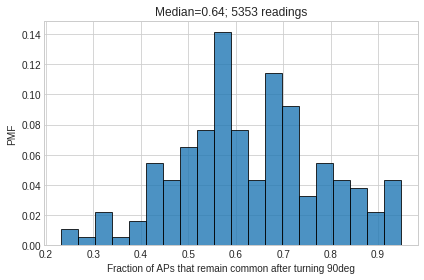

<Figure size 432x288 with 0 Axes>

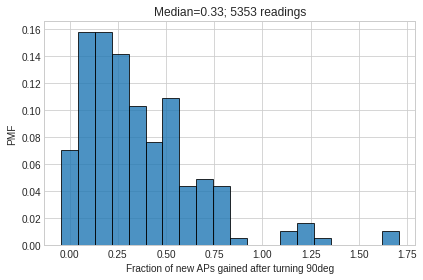

<Figure size 432x288 with 0 Axes>

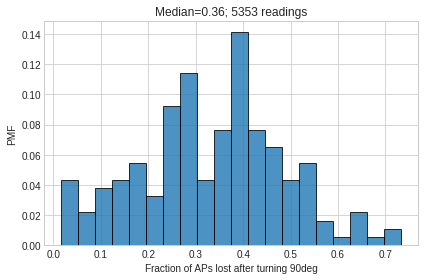

<Figure size 432x288 with 0 Axes>

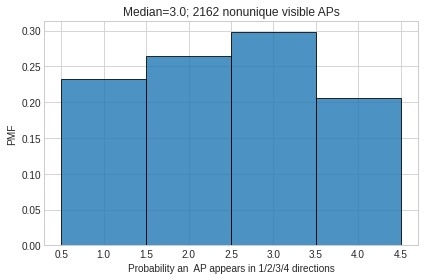

<Figure size 432x288 with 0 Axes>

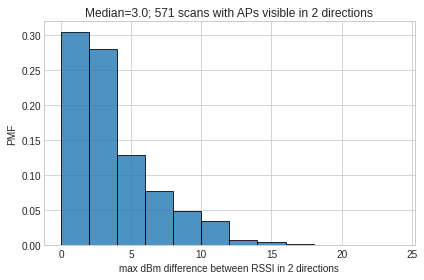

<Figure size 432x288 with 0 Axes>

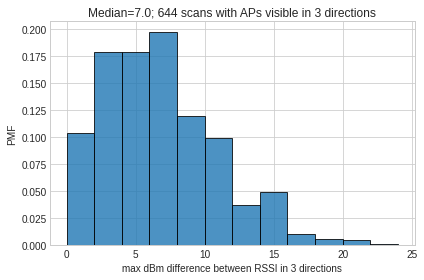

<Figure size 432x288 with 0 Axes>

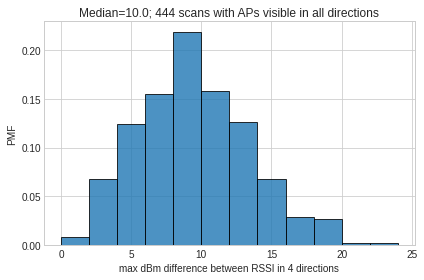

In [194]:
#APstats = rAPstats

stat='common'    
fig = plt.figure()
a = np.array(APstats[stat])
hist_bars, bins_out = np.histogram(APstats[stat], bins=20, density=False)
bin_width = bins_out[1] - bins_out[0]
hist_bars = hist_bars / len(APstats[stat])
plt.bar(bins_out[:-1], hist_bars, width=bin_width, ec='k', alpha=0.8)
plt.xlabel('Fraction of APs that remain common after turning 90deg')
plt.ylabel("PMF")
plt.title(f"Median={np.median(APstats[stat]):.2f}; {sum(APstats['total0'])} readings")
plt.tight_layout()
plt.show()
fig.savefig(f"{stat}.pdf", bbox_inches='tight')

stat='gained'    
fig = plt.figure()
a = np.array(APstats[stat])
hist_bars, bins_out = np.histogram(APstats[stat], bins=20, density=False)
bin_width = bins_out[1] - bins_out[0]
hist_bars = hist_bars / len(APstats[stat])
fig = plt.figure()
plt.bar(bins_out[:-1], hist_bars, width=bin_width, ec='k', alpha=0.8)
plt.xlabel('Fraction of new APs gained after turning 90deg')
plt.title(f"Median={np.median(APstats[stat]):.2f}; {sum(APstats['total0'])} readings")
plt.ylabel("PMF")
plt.tight_layout()
plt.show()
fig.savefig(f"{stat}.pdf", bbox_inches='tight')


stat='lost'    
fig = plt.figure()
a = np.array(APstats[stat])
hist_bars, bins_out = np.histogram(APstats[stat], bins=20, density=False)
bin_width = bins_out[1] - bins_out[0]
hist_bars = hist_bars / len(APstats[stat])
fig = plt.figure()
plt.bar(bins_out[:-1], hist_bars, width=bin_width, ec='k', alpha=0.8)
plt.xlabel('Fraction of APs lost after turning 90deg')
plt.title(f"Median={np.median(APstats[stat]):.2f}; {sum(APstats['total0'])} readings")
plt.ylabel("PMF")
plt.tight_layout()
plt.show()
fig.savefig(f"{stat}.pdf", bbox_inches='tight')

stat='ndirs'    
fig = plt.figure()
a = np.array(APstats[stat])
hist_bars, bins_out = np.histogram(APstats[stat], bins=[1,2,3,4,5], density=False)
bin_width = bins_out[1] - bins_out[0]
hist_bars = hist_bars / len(APstats[stat])
fig = plt.figure()
plt.bar(bins_out[:-1], hist_bars, width=bin_width, ec='k', alpha=0.8)
plt.xlabel('Probability an  AP appears in 1/2/3/4 directions')
plt.ylabel("PMF")
plt.title(f"Median={np.median(APstats[stat])}; {len(APstats[stat])} nonunique visible APs")
plt.tight_layout()
plt.show()
fig.savefig(f"{stat}.pdf", bbox_inches='tight')


stat='dbmdiff2'    
fig = plt.figure()
a = np.array(APstats[stat])
hist_bars, bins_out = np.histogram(APstats[stat], bins=np.arange(1,26,2), density=False)
bin_width = bins_out[1] - bins_out[0]
hist_bars = hist_bars / len(APstats[stat])
fig = plt.figure()
plt.bar(bins_out[:-1], hist_bars, width=bin_width, ec='k', alpha=0.8)
plt.xlabel('max dBm difference between RSSI in 2 directions')
plt.ylabel("PMF")
plt.title(f"Median={np.median(APstats[stat])}; {len(APstats[stat])} scans with APs visible in 2 directions")
plt.tight_layout()
plt.show()
fig.savefig("max_dbm_diff_2dir.pdf", bbox_inches='tight')

stat='dbmdiff3'    
fig = plt.figure()
a = np.array(APstats[stat])
hist_bars, bins_out = np.histogram(APstats[stat], bins=np.arange(1,26,2), density=False)
bin_width = bins_out[1] - bins_out[0]
hist_bars = hist_bars / len(APstats[stat])
fig = plt.figure()
plt.bar(bins_out[:-1], hist_bars, width=bin_width, ec='k', alpha=0.8)
plt.xlabel('max dBm difference between RSSI in 3 directions')
plt.ylabel("PMF")
plt.title(f"Median={np.median(APstats[stat])}; {len(APstats[stat])} scans with APs visible in 3 directions")
plt.tight_layout()
plt.show()
fig.savefig("max_dbm_diff_3dir.pdf", bbox_inches='tight')

stat='dbmdiff4'    
fig = plt.figure()
a = np.array(APstats[stat])
hist_bars, bins_out = np.histogram(APstats[stat], bins=np.arange(1,26,2), density=False)
bin_width = bins_out[1] - bins_out[0]
hist_bars = hist_bars / len(APstats[stat])
fig = plt.figure()
plt.bar(bins_out[:-1], hist_bars, width=bin_width, ec='k', alpha=0.8)
plt.xlabel('max dBm difference between RSSI in 4 directions')
plt.ylabel("PMF")
plt.title(f"Median={np.median(APstats[stat])}; {len(APstats[stat])} scans with APs visible in all directions")
plt.tight_layout()
plt.show()
fig.savefig("max_dbm_diff_4dir.pdf", bbox_inches='tight')



#for mac  in etaje[0][2]['fingerprints'][3]['wifi']:
#    print(mac, etaje[0][2]['fingerprints'][3]['wifi'][mac]['rssi'])


<Figure size 432x288 with 0 Axes>

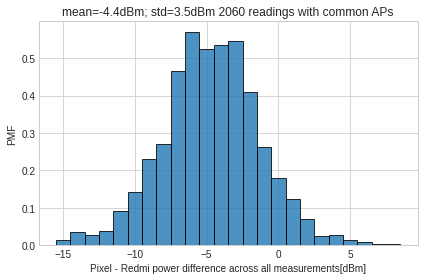

In [195]:

pix_red_diff = []
for pe, re in zip([petaje[0]], [retaje[0]]): 
    for pc, rc in zip(pe, re):
        pf, rf = pc['fingerprints'], rc['fingerprints']
        pallf = merge_wifi_fingerprints(pf)['wifi']
        rallf = merge_wifi_fingerprints(rf)['wifi']
        for mac in rallf:
            if mac in pallf: 
                pix_red_diff.append(np.mean(pallf[mac]['rssi']) - np.mean(rallf[mac]['rssi']))
np.percentile(pix_red_diff, [5, 50, 95])

fig = plt.figure()

hist_bars, bins_out = np.histogram(pix_red_diff, bins=np.arange(-15,10,1), density=False)
bin_width = bins_out[1] - bins_out[0]
hist_bars = hist_bars / len(APstats[stat])
fig = plt.figure()
plt.bar(bins_out[:-1], hist_bars, width=bin_width, ec='k', alpha=0.8)
plt.xlabel('Pixel - Redmi power difference across all measurements[dBm]')
plt.ylabel("PMF")
plt.title(f"mean={np.mean(pix_red_diff):.1f}dBm; std={np.std(pix_red_diff):.1f}dBm {len(pix_red_diff)} readings with common APs")
plt.tight_layout()
plt.show()
fig.savefig("pix_red_dbm_diff.pdf", bbox_inches='tight')


In [149]:


print("\n22=", merge_wifi_fingerprints(etaje[6][22]['fingerprints'])['wifi'])
w = merge_wifi_fingerprints(etaje[6][22]['fingerprints'])['wifi']
for mac in w:
    print(len(w[mac]['rssi']))

print("\n23=", merge_wifi_fingerprints(etaje[6][23]['fingerprints'])['wifi'])

print("\n24=", merge_wifi_fingerprints(etaje[6][24]['fingerprints'])['wifi'])

print("22-23 ", compare_locations(etaje[6][22], etaje[6][23], braycurtis, 'Bestdir'))
print("22-24 ", compare_locations(etaje[6][22], etaje[6][22], braycurtis, 'Bestdir'))




22= {'84:b2:61:6d:52:af': {'ssid': 'eduroam', 'frequency': '5180', 'rssi': [-42, -41, -40, -39]}, '84:b2:61:6d:52:ae': {'ssid': 'UPB-Guest', 'frequency': '5180', 'rssi': [-42, -41, -39, -39]}, '84:b2:61:6d:52:ad': {'ssid': 'PRECIS', 'frequency': '5180', 'rssi': [-42, -40, -40, -39]}, '84:b2:61:6d:52:a2': {'ssid': 'PRECIS', 'frequency': '2412', 'rssi': [-48, -46, -43, -40]}, '84:b2:61:6d:52:a1': {'ssid': 'UPB-Guest', 'frequency': '2412', 'rssi': [-48, -46, -43]}, '84:b2:61:6d:5d:7f': {'ssid': 'eduroam', 'frequency': '5220', 'rssi': [-75, -74, -71, -67]}, '84:b2:61:6d:52:a0': {'ssid': 'eduroam', 'frequency': '2412', 'rssi': [-48, -46, -43, -39]}, '84:b2:61:6d:5d:7e': {'ssid': 'UPB-Guest', 'frequency': '5220', 'rssi': [-75, -75, -71, -68]}, '84:b2:61:6d:5d:7d': {'ssid': 'PRECIS', 'frequency': '5220', 'rssi': [-75, -74, -71, -68]}, '84:b2:61:47:e2:cf': {'ssid': 'eduroam', 'frequency': '5280', 'rssi': [-59, -54, -50, -50]}, '84:b2:61:47:e2:ce': {'ssid': 'UPB-Guest', 'frequency': '5280', 'r

In [219]:
macs = []
for e in petaje:     
    macse = set([])
    for c in e:
        f = c['fingerprints']
        allf = merge_wifi_fingerprints(f)['wifi']
        macse = macse | set(allf.keys())
    macs.append(macse)    
    print("macs = ", len(macse))    
    
print("l = ", len(macs[0] & macs[2]))    
    
for me in macs:
    for ne in macs: 
        print("%2d " % len(me & ne), end='')
    print("")    

print("Difference:")
for me in macs:
    for ne in macs: 
        print("%2d " % len(me - ne), end='')
    print("")        

macs =  83
macs =  75
macs =  73
macs =  75
macs =  68
macs =  76
macs =  74
macs =  50
l =  27
83 49 27  3  0  0  0  0 
49 75 53 29  0  0  0  0 
27 53 73 48 19  0  0  0 
 3 29 48 75 44 24  0  0 
 0  0 19 44 68 48 24  0 
 0  0  0 24 48 76 49 25 
 0  0  0  0 24 49 74 50 
 0  0  0  0  0 25 50 50 
Difference:
 0 34 56 80 83 83 83 83 
26  0 22 46 75 75 75 75 
46 20  0 25 54 73 73 73 
72 46 27  0 31 51 75 75 
68 68 49 24  0 20 44 68 
76 76 76 52 28  0 27 51 
74 74 74 74 50 25  0 24 
50 50 50 50 50 25  0  0 
